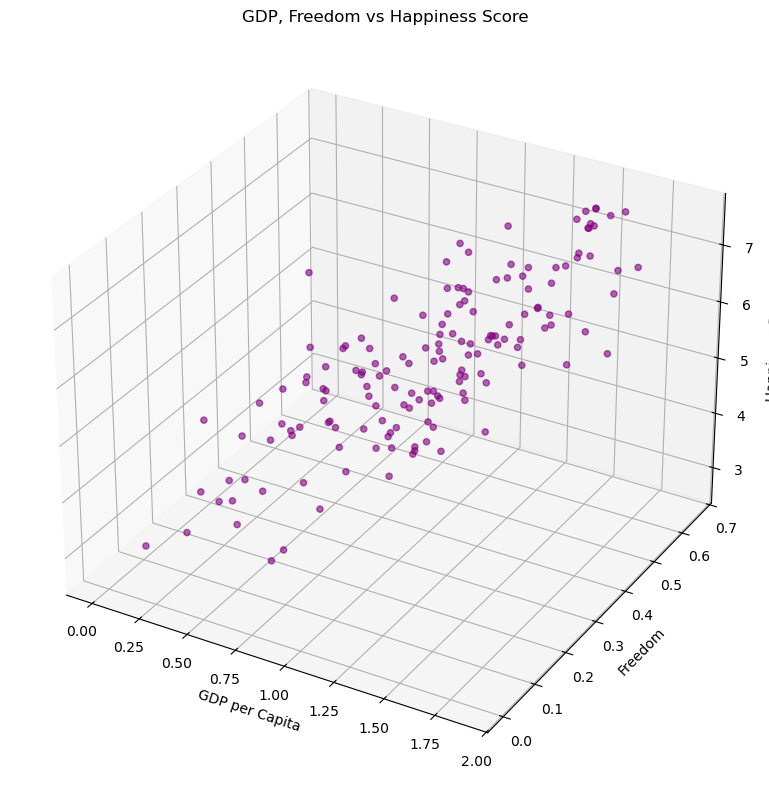

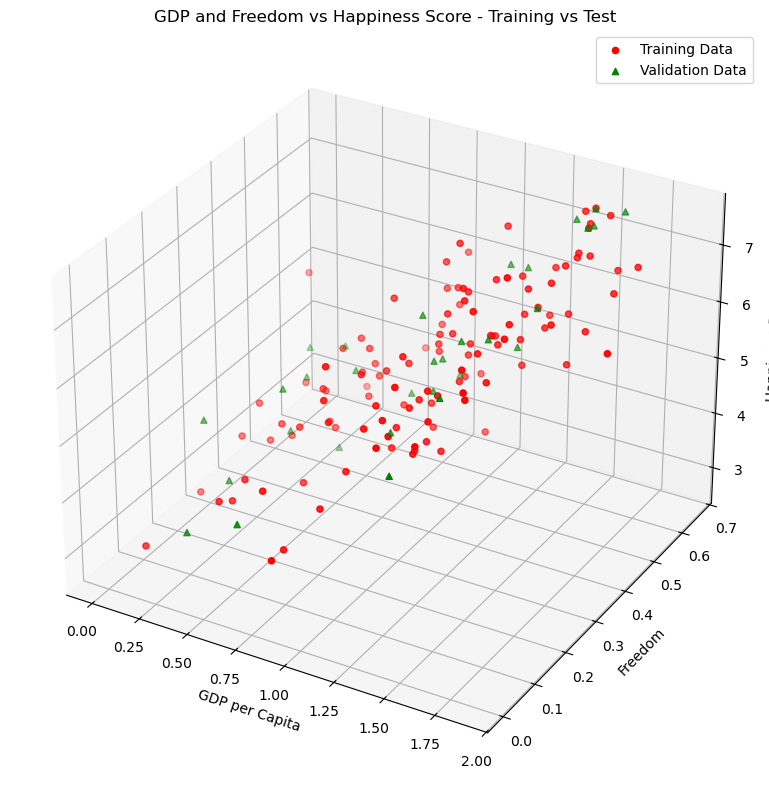

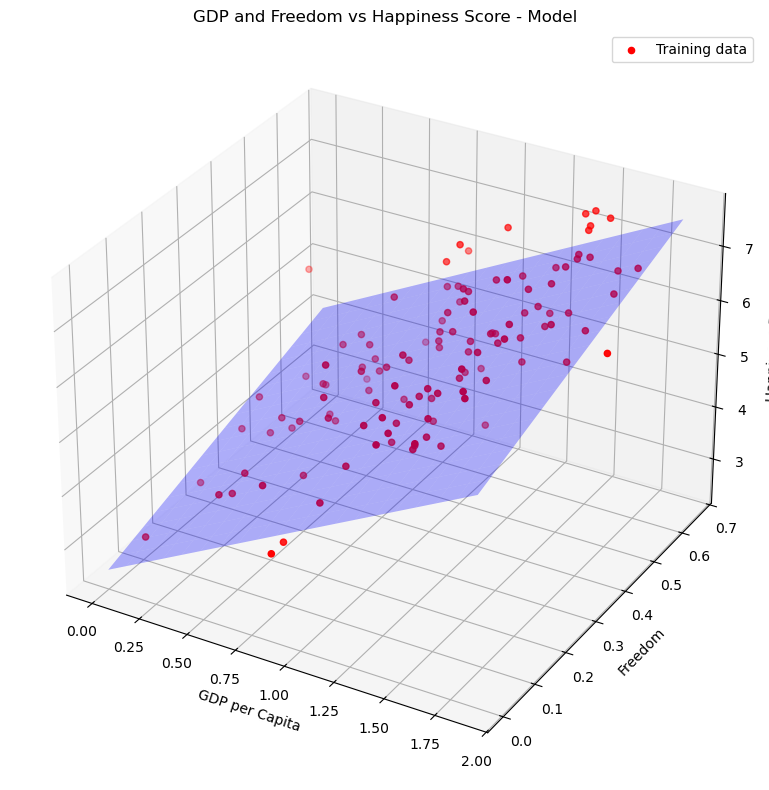

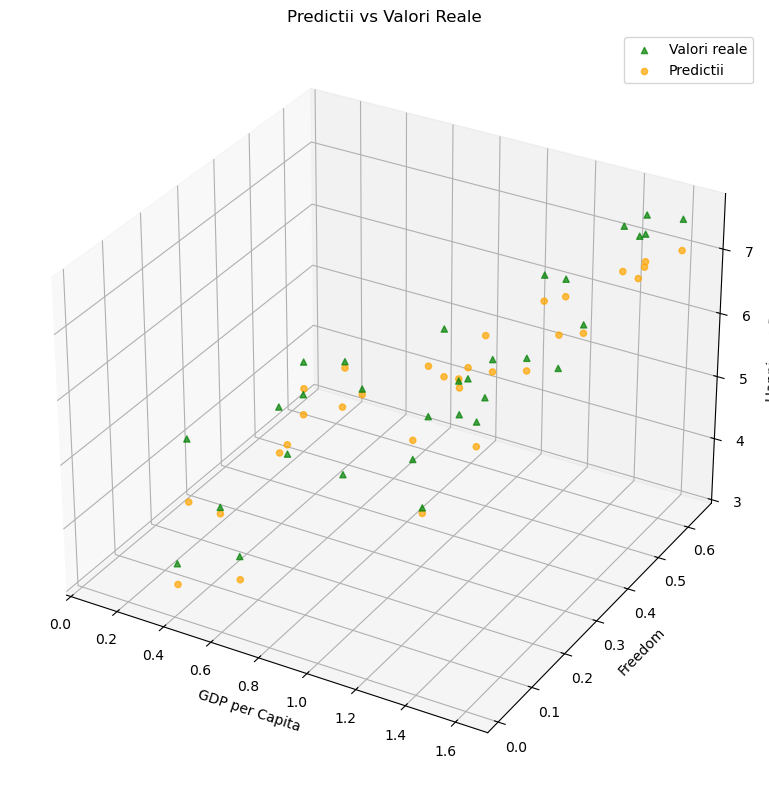

MSE: 0.276726


In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
"""
w=(X^(T+1))^−1*X^T*y
"""

class MyBivariateRegression:
    def __init__(self):
        self.coefs = []
    # transpusa matrice
    @staticmethod
    def matrix_transpose(matrix):
        rows = len(matrix)
        cols = len(matrix[0])
        return [[matrix[i][j] for i in range(rows)] for j in range(cols)]

    # inmultire doua matrix
    @staticmethod
    def matrix_multiply(a, b):
        rows_a, cols_a = len(a), len(a[0])
        rows_b, cols_b = len(b), len(b[0])
        result = [[0 for _ in range(cols_b)] for _ in range(rows_a)]
        for i in range(rows_a):
            for j in range(cols_b):
                for k in range(cols_a):
                    result[i][j] += a[i][k] * b[k][j]
        return result
    
    # eliminare gauss
    @staticmethod
    def matrix_determinant(matrix):
        n = len(matrix)
        a = [row[:] for row in matrix]
        det = 1.0
        for i in range(n):
            max_val = abs(a[i][i])
            max_row = i
            for k in range(i + 1, n):
                if abs(a[k][i]) > max_val:
                    max_val = abs(a[k][i])
                    max_row = k
            if max_val < 1e-10:
                return 0.0
            if max_row != i:
                a[i], a[max_row] = a[max_row], a[i]
                det = -det
            pivot = a[i][i]
            det *= pivot
            for j in range(i, n):
                a[i][j] /= pivot
            for k in range(i + 1, n):
                factor = a[k][i]
                for j in range(i, n):
                    a[k][j] -= factor * a[i][j]
        return det

    # -1 ^ (i + j) * matrix ramsa prin taiaere
    def matrix_cofactor(self, matrix, i, j):
        n = len(matrix)
        minor = [[matrix[r][c] for c in range(n) if c != j] for r in range(n) if r != i]
        return self.matrix_determinant(minor) * (-1) ** (i + j)

    def matrix_adj(self, matrix):
        n = len(matrix)
        return [[self.matrix_cofactor(matrix, j, i) for j in range(n)] for i in range(n)]

    def matrix_inverse(self, matrix):
        det = self.matrix_determinant(matrix)
        # evitare 0 prin regularizare
        if abs(det) < 1e-10:
            reg = [row[:] for row in matrix]
            lambda_reg = 0.01
            for i in range(len(reg)):
                reg[i][i] += lambda_reg
            det = self.matrix_determinant(reg)
            adj = self.matrix_adj(reg)
        else:
            adj = self.matrix_adj(matrix)
        return [[adj[i][j] / det for j in range(len(matrix))] for i in range(len(matrix))]
    
    # prima coloana 1 pt termenul free -> w[0]
    @staticmethod
    def add_one(inputs):
        return [[1] + row for row in inputs]

    def fit(self, inputs, outputs):
        x = self.add_one(inputs)
        x_t = self.matrix_transpose(x) # transpusa
        x_t_x = self.matrix_multiply(x_t, x) # X^(T + 1)
        x_t_x_inv = self.matrix_inverse(x_t_x) # Inversa
        y = [[val] for val in outputs]
        x_t_y = self.matrix_multiply(x_t, y) # X ^ t * y
        x_t_y = [val[0] for val in x_t_y]
        coefs = []
        # inmultire inversa cu X ^ t * y
        for i in range(len(x_t_x_inv)):
            coef = 0
            for j in range(len(x_t_y)):
                coef += x_t_x_inv[i][j] * x_t_y[j]
            coefs.append(coef)
        self.coefs = coefs
        return self.coefs

    def predict(self, inputs):
        return [self.coefs[0] + self.coefs[1] * row[0] + self.coefs[2] * row[1] for row in inputs]


def load_data(file_name, input_names, output_name):
    data = []
    header = []
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                header = row
            else:
                data.append(row)
            line_count += 1
    input_indices = [header.index(var) for var in input_names]
    output_idx = header.index(output_name)
    all_inputs = []
    for i in range(len(data)):
        row_inputs = []
        has_missing = False
        for idx in input_indices:
            if data[i][idx] == '':
                has_missing = True
                row_inputs.append(None)
            else:
                row_inputs.append(float(data[i][idx]))

        output_val = None if data[i][output_idx] == '' else float(data[i][output_idx])

        all_inputs.append((row_inputs, output_val, has_missing or output_val is None))

    means = []
    for j in range(len(input_indices)):
        valid_values = [all_inputs[i][0][j] for i in range(len(all_inputs)) if all_inputs[i][0][j] is not None]
        means.append(sum(valid_values) / len(valid_values))

    valid_outputs = [all_inputs[i][1] for i in range(len(all_inputs)) if all_inputs[i][1] is not None]
    output_mean = sum(valid_outputs) / len(valid_outputs)

    filtered_inputs = []
    filtered_outputs = []

    for i in range(len(all_inputs)):
        input_values = []
        for j in range(len(input_indices)):
            if all_inputs[i][0][j] is None:
                input_values.append(means[j])
            else:
                input_values.append(all_inputs[i][0][j])

        filtered_inputs.append(input_values)

        if all_inputs[i][1] is None:
            filtered_outputs.append(output_mean)
        else:
            filtered_outputs.append(all_inputs[i][1])

    return filtered_inputs, filtered_outputs


file_path = 'data/v3_world-happiness-report-2017.csv'
inputs_gdp_freedom, outputs_happiness = load_data(file_path, ['Economy..GDP.per.Capita.', 'Freedom'], 'Happiness.Score')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([row[0] for row in inputs_gdp_freedom], [row[1] for row in inputs_gdp_freedom], outputs_happiness,
           c='purple', marker='o', alpha=0.6)
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Freedom')
ax.set_zlabel('Happiness Score')
plt.title('GDP, Freedom vs Happiness Score')
plt.tight_layout()
plt.show()

np.random.seed(5)
indexes = [i for i in range(len(inputs_gdp_freedom))]

train_sample = np.random.choice(indexes, int(0.8 * len(inputs_gdp_freedom)), replace=False)
validation_sample = [i for i in indexes if i not in train_sample]
train_inputs = [inputs_gdp_freedom[i] for i in train_sample]
train_outputs = [outputs_happiness[i] for i in train_sample]
validation_inputs = [inputs_gdp_freedom[i] for i in validation_sample]
validation_outputs = [outputs_happiness[i] for i in validation_sample]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([inp[0] for inp in train_inputs], [inp[1] for inp in train_inputs], train_outputs, c='red', marker='o',
           label='Training Data')
ax.scatter([inp[0] for inp in validation_inputs], [inp[1] for inp in validation_inputs], validation_outputs, c='green',
           marker='^', label='Validation Data')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Freedom')
ax.set_zlabel('Happiness Score')
ax.set_title('GDP and Freedom vs Happiness Score - Training vs Test')
ax.legend()
plt.tight_layout()
plt.show()

model = MyBivariateRegression()
w = model.fit(train_inputs, train_outputs)
w0, w1, w2 = w[0], w[1], w[2]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([row[0] for row in train_inputs], [row[1] for row in train_inputs], train_outputs, c='r', marker='o',
           label='Training data')
x1_min, x1_max = min([row[0] for row in train_inputs]), max([row[0] for row in train_inputs])
x2_min, x2_max = min([row[1] for row in train_inputs]), max([row[1] for row in train_inputs])
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 20), np.linspace(x2_min, x2_max, 20))
zz = w0 + w1 * xx1 + w2 * xx2
surf = ax.plot_surface(xx1, xx2, zz, alpha=0.3, color='blue')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Freedom')
ax.set_zlabel('Happiness Score')
ax.set_title('GDP and Freedom vs Happiness Score - Model')
ax.legend()
plt.tight_layout()
plt.show()

validation_predictions = model.predict(validation_inputs)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
x1 = [row[0] for row in validation_inputs]
x2 = [row[1] for row in validation_inputs]
ax.scatter(x1, x2, validation_outputs, c='green', marker='^', alpha=0.7, label='Valori reale')
ax.scatter(x1, x2, validation_predictions, c='orange', marker='o', alpha=0.7, label='Predictii')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Freedom')
ax.set_zlabel('Happiness Score')
ax.set_title('Predictii vs Valori Reale')
ax.legend()
plt.tight_layout()
plt.show()

error = sum((validation_outputs[i] - validation_predictions[i]) ** 2 for i in range(len(validation_outputs))) / len(
    validation_outputs)
print(f"MSE: {error:.6f}")